In [1]:
import torch
import numpy as np
import os
from torch import nn, optim
import torch.nn.functional as F
import h5py
import pickle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from scipy.misc import imsave
import matplotlib.pyplot as plt
import cv2

In [2]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 with Max-Q Design'

In [3]:
class AdlDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, hdf5_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        f = h5py.File(hdf5_file, 'r')

        self.dset = f['default']
        self.transform = transform
        
        with open("adl_indices.pkl","rb") as f:
            self.indices = pickle.load(f)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx2 = self.indices[idx]
        sample = self.dset[idx2:idx2+10]
        sample = sample.transpose([1,2,3,0])
        sample = sample.reshape([240,320,-1])
        sample = sample[:,40:280,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class Generator(nn.Module):
    '''
    The Generator class which contains the entire U-Net Architecture.
    '''
    
    def __init__(self):
        super().__init__()
        
        # Layer 1 - Left
        self.conv1 = nn.Conv2d(18, 18,kernel_size=(2,2),stride=(2,2),padding=(8,8)) #size (20,128,128)
        self.PReLU1 = nn.PReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=18)
        self.conv2 = nn.Conv2d(18, 32,kernel_size=(3,3),stride=(1,1),padding=1) #size (32,128,128)
        self.PReLU2 = nn.PReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=32)
        
        # Layer 2 - Left
        self.conv3 = nn.Conv2d(32, 32,kernel_size=(3,3),stride=(1,1),padding=0,dilation=4) #size (32,120,120)
        self.PReLU3 = nn.PReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(32, 64,kernel_size=(3,3),stride=(1,1),padding=1) #size (64,120,120)
        self.PReLU4 = nn.PReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=64)
        
        # Layer 3 - Left
        self.conv5 = nn.Conv2d(64, 64,kernel_size=(3,3),stride=(1,1),padding=0,dilation=8) #size (64,104,104)
        self.PReLU5 = nn.PReLU()
        self.bn5 = torch.nn.BatchNorm2d(num_features=64)
        self.conv6 = nn.Conv2d(64, 128,kernel_size=(3,3),stride=(1,1),padding=1)#size (128,104,104)
        self.PReLU6 = nn.PReLU()
        self.bn6 = torch.nn.BatchNorm2d(num_features=128)
        
        # Layer 4 - Middle
        self.conv7_part1 = nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=0,dilation=16) #size (128,72,72) 
        self.PReLU7_part1 = nn.PReLU()
        self.bn7_part1 = torch.nn.BatchNorm2d(num_features=128)
        
        self.conv7_part2 = nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=1) #size (128,72,72) 
        self.PReLU7_part2 = nn.PReLU()
        self.bn7_part2 = torch.nn.BatchNorm2d(num_features=128)
        
        self.deconv8 = nn.ConvTranspose2d(128,128,kernel_size=(3,3),stride=(1,1),padding=0,dilation=16) #size (64,104,104)
        
        # Layer 5 - Right
        self.conv9 = nn.Conv2d(128+128,64,kernel_size=(3,3),stride=(1,1),padding=1) #size (64,104,104)
        self.PReLU9 = nn.PReLU()
        self.bn9 = torch.nn.BatchNorm2d(num_features=64)
        self.conv10 = nn.Conv2d(64,64, kernel_size=(3,3),stride=(1,1),padding=1)#size (64,104,104)                          
        self.PReLU10 = nn.PReLU()
        self.bn10 = torch.nn.BatchNorm2d(num_features=64)
        
        self.deconv11 = nn.ConvTranspose2d(64,64,kernel_size=(3,3),stride=(1,1),padding=0,dilation=8) #size (64,120,120)
        
        # Layer 6 - Right
        self.conv12 = nn.Conv2d(64+64,32,kernel_size=(3,3),stride=(1,1),padding=1) #size (32,120,120)
        self.PReLU12 = nn.PReLU()
        self.bn12 = torch.nn.BatchNorm2d(num_features=32)
        self.conv13 = nn.Conv2d(32,32,kernel_size=(3,3),stride=(1,1),padding=1) #size (32,120,120)
        self.PReLU13 = nn.PReLU()
        self.bn13 = torch.nn.BatchNorm2d(num_features=32)
        
        self.deconv14 = nn.ConvTranspose2d(32,32,kernel_size=(3,3),stride=(1,1),padding=0,dilation=4) #size (32,128,128)
        
        # Layer 7 - Right
        self.conv15 = nn.Conv2d(32+32,20,kernel_size=(3,3),stride=(1,1),padding=1) #size (20,128,128)
        self.PReLU15 = nn.PReLU()
        self.bn15 = torch.nn.BatchNorm2d(num_features=20)
        self.conv16 = nn.Conv2d(20,20,kernel_size=(3,3),stride=(1,1),padding=1) #size (20,128,128)
        self.PReLU16 = nn.PReLU()
        self.bn16 = torch.nn.BatchNorm2d(num_features=20)
        
        self.deconv17 = nn.ConvTranspose2d(20,20,kernel_size=(2,2),stride=(2,2),padding=(8,8),dilation=1) #size (20,240,240)
        
        # Layer 8 - Right
        self.conv18 = nn.Conv2d(20,20,kernel_size=(3,3),stride=(1,1),padding=1) #size (20,240,240)
        self.PReLU18 = nn.PReLU()
        self.bn18 = torch.nn.BatchNorm2d(num_features=20)
        self.conv19 = nn.Conv2d(20,2,kernel_size=(3,3),stride=(1,1),padding=1) #size (2,240,240)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        x1 = self.bn1(self.PReLU1(self.conv1(x)))
        x2 = self.bn2(self.PReLU2(self.conv2(x1)))
        x3 = self.bn3(self.PReLU3(self.conv3(x2)))
        x4 = self.bn4(self.PReLU4(self.conv4(x3)))
        x5 = self.bn5(self.PReLU5(self.conv5(x4)))
        x6 = self.bn6(self.PReLU6(self.conv6(x5)))
        x7 = self.bn7_part1(self.PReLU7_part1(self.conv7_part1(x6)))
        x7 = self.bn7_part2(self.PReLU7_part2(self.conv7_part2(x7)))
        
        x8 = self.deconv8(x7)
        
        input_9 = torch.cat((x8,x6),dim=1)
        assert( input_9.shape[1:] == (256,104,104) )
        x9 = self.bn9(self.PReLU9(self.conv9(input_9)))
        x10 = self.bn10(self.PReLU10(self.conv10(x9)))
        
        x11 = self.deconv11(x10)
        
        input_12 = torch.cat((x11,x4), dim=1)
        assert( input_12.shape[1:] == (128,120,120) )
        x12 = self.bn12(self.PReLU12(self.conv12(input_12)))
        x13 = self.bn13(self.PReLU13(self.conv13(x12)))
        
        x14 = self.deconv14(x13)
        
        input_15 = torch.cat((x14,x2), dim=1)
        assert( input_15.shape[1:] == (64,128,128) )
        x15 = self.bn15(self.PReLU15(self.conv15(input_15)))
        x16 = self.bn16(self.PReLU16(self.conv16(x15)))
        
        x17 = self.deconv17(x16)
        
        x18 = self.bn18(self.PReLU18(self.conv18(x17)))
        x19 = self.conv19(x18)
        x20 = self.sig(x19)
        
        return x20

In [5]:
class Discriminator(nn.Module):
    '''
    The Discriminator class which contains the entire U-Net Architecture.
    '''
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(20, 16,kernel_size=(2,2),stride=(2,2),padding=(8,8)) #size (16,128,128)
        self.PReLU1 = nn.PReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=16)
        
        self.conv2 = nn.Conv2d(16, 8,kernel_size=(2,2),stride=(2,2)) #size (8,64,64)
        self.PReLU2 = nn.PReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=8)
        
        self.conv3 = nn.Conv2d(8, 4,kernel_size=(2,2),stride=(2,2))  #size (4,32,32)
        self.PReLU3 = nn.PReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=4)
        
        self.conv4 = nn.Conv2d(4,2, kernel_size=(2,2),stride=(2,2)) #size (2,16,16)
        self.PReLU4 = nn.PReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=2)
        
        self.conv5 = nn.Conv2d(2,1, kernel_size=(2,2),stride=(2,2)) #size (1,8,8)
        self.PReLU5 = nn.PReLU()
        self.bn5 = torch.nn.BatchNorm2d(num_features=1)
        
        self.fc1 = nn.Linear(64,32)
        self.PReLU_fc1 = nn.PReLU()
        
        self.fc2 = nn.Linear(32,16)
        self.PReLU_fc2 = nn.PReLU()
        
        self.fc3 = nn.Linear(16,8)
        self.PReLU_fc3 = nn.PReLU()
        
        self.fc4 = nn.Linear(8,1)
        self.sig_fc4 = nn.Sigmoid()
        
    def forward(self, x):
        
        # Convs
        x1 = self.bn1(self.PReLU1(self.conv1(x)))
        x2 = self.bn2(self.PReLU2(self.conv2(x1)))
        x3 = self.bn3(self.PReLU3(self.conv3(x2)))
        x4 = self.bn4(self.PReLU4(self.conv4(x3)))
        x5 = self.bn5(self.PReLU5(self.conv5(x4)))
        
        # Flatten
        x5 = x5.view(x.shape[0], -1)
        #print(x5.shape)
        
        # Fully Connected
        x6 = self.PReLU_fc1(self.fc1(x5))
        x7 = self.PReLU_fc2(self.fc2(x6))
        x8 = self.PReLU_fc3(self.fc3(x7))
        x9 = self.sig_fc4(self.fc4(x8))
        
        return x9

In [ ]:
batch_size = 16

transform = transforms.Compose([transforms.ToTensor()])
adl_dset = AdlDataset("adl_dataset.hdf5",transform)
dataloader = DataLoader(adl_dset, batch_size=batch_size,
                        shuffle=True, num_workers=4)

# Final Model
gen = Generator().cuda()
disc = Discriminator().cuda()

# Sqaured Error Loss and Binary Cross Entropy Loss
mse_cri = nn.MSELoss(reduction = 'mean').cuda()
entropy_cri_fake = nn.BCELoss(reduction = 'mean').cuda()
entropy_cri_real = nn.BCELoss(reduction = 'mean').cuda()
gen_cri_faking = nn.BCELoss(reduction = 'mean').cuda()

# Optimizers for generator and discriminator
opti_gen = torch.optim.Adam(list(gen.parameters()))
opti_disc = torch.optim.Adam(list(disc.parameters()))

In [ ]:
for epoch in range(100):
    
    torch.save(gen.state_dict(),  "./parameters/gen_" + "epoch_" + str(epoch-1) + ".pt")        
    torch.save(disc.state_dict(), "./parameters/disc_" + "epoch_" + str(epoch-1) + ".pt")
    
    gen_loss = 0
    disc_loss = 0
    
    for index,data in enumerate(dataloader) :
        
        ##### Generator #####
        temp_batch_size = data.shape[0]
        
        # Previous 9 frames
        input_ = data[:,0:18,:,:].cuda()
        #print(input_.shape)
        assert(input_.shape == torch.Size([temp_batch_size,18,240,240]))

        # Ground truth of 10th frame for batch_size sets
        ground_ = data[:,18:,:,:].cuda()
        assert(ground_.shape == torch.Size([temp_batch_size,2,240,240]))

        # Important !!
        opti_gen.zero_grad()
        opti_disc.zero_grad()

        # Prediction for 10th frame for batch_size sets 
        pred_ = gen.forward(input_).cuda()

        # Input to the discriminator
        disc_input = torch.cat((input_,pred_), dim = 1).cuda()
        assert(disc_input.shape == torch.Size([temp_batch_size,20,240,240]))

        # Prediction by discriminator
        pred_disc_fake = disc.forward(disc_input).cuda()
        assert( pred_disc_fake.shape[1:] == torch.Size([1]))

        ##### Discriminator #####

        # Prediction by discriminator        
        pred_disc_real = disc.forward(data.cuda()).cuda()
        
        ##### Loss #####
        if index%3 == 0 :
            
            # Cross Entropy Loss for discriminator
            loss_entropy_fake = entropy_cri_fake(pred_disc_fake,torch.zeros([temp_batch_size,1]).cuda())
            loss_entropy_real = entropy_cri_real(pred_disc_real,torch.ones([temp_batch_size,1]).cuda())
            
            # Accumalate gradients for discriminator
            total_loss = loss_entropy_fake + loss_entropy_real 
            total_loss.backward()
            
            ##### backprop #####
            opti_disc.step()
            
            # Accumalate loss
            disc_loss += loss_entropy_fake.item() + loss_entropy_real.item()
            
            # Print
            if (index % 9 == 0) :
                print("Batch : {}".format(index))
                print("Loss : REAL = {} FAKE = {}".format(loss_entropy_real.item(),loss_entropy_fake.item()))
            
        else :
            
             # MSE
            loss_mse = mse_cri(pred_,ground_).cuda()
        
            # Non saturatin loss for generator
            loss_gen_fake = gen_cri_faking(pred_disc_fake,torch.ones([temp_batch_size,1]).cuda())
            
            # Accumalate gradients for generator
            total_loss = loss_mse + loss_gen_fake
            total_loss.backward()
        
            ##### backprop #####
            opti_gen.step()

            # Accumalate loss
            gen_loss += loss_mse.item() + loss_gen_fake.item()
        
            if (index % 8) == 0 :
                print("Batch : {}".format(index))
                print("Loss : MSE = {} FAKE = {}".format(loss_mse.item(),loss_gen_fake.item()))
    
    print("Final Loss : GEN = {} DISC = {}".format(gen_loss,disc_loss))

In [ ]:
next(gen.parameters()).is_cuda

In [ ]:
next(disc.parameters()).is_cuda

In [6]:
### Testing the model's outputs on some part of the training data ###

batch_size = 16

transform = transforms.Compose([transforms.ToTensor()])
adl_dset = AdlDataset("adl_dataset.hdf5",transform)
dataloader = DataLoader(adl_dset, batch_size=batch_size,
                        shuffle=True, num_workers=4)

gen = Generator().cuda()
gen.load_state_dict(torch.load('/home/alex/Desktop/Fall_Dataset_GANs/nonfall/parameters/gen_epoch_0.pt'))
gen = gen.eval()

disc = Discriminator().cuda()
disc.load_state_dict(torch.load('/home/alex/Desktop/Fall_Dataset_GANs/nonfall/parameters/disc_epoch_0.pt'))
disc = disc.eval()

In [ ]:
# def convert_polar(l):
#     hsv = np.zeros((l.shape[0], l.shape[1], l.shape[2], 2), dtype=np.float32)
#     flow_magnitude, flow_angle = cv2.cartToPolar(l[..., 0].astype(np.float32), l[..., 1].astype(np.float32))
#     nans = np.isnan(flow_magnitude)
#     if np.any(nans):
#         nans = np.where(nans)
#         flow_magnitude[nans] = 0.
#     hsv[..., 0] = flow_angle/(2.0*np.pi)
#     hsv[..., 1] = cv2.normalize(flow_magnitude, None, 0, 1, cv2.NORM_MINMAX)
#     return hsv

In [9]:
def flow_to_img(flow, normalize=True, info=None, flow_mag_max=None):
    """Convert flow to viewable image, using color hue to encode flow vector orientation, and color saturation to
    encode vector length. This is similar to the OpenCV tutorial on dense optical flow, except that they map vector
    length to the value plane of the HSV color model, instead of the saturation plane, as we do here.
    Args:
        flow: optical flow
        normalize: Normalize flow to 0..255
        info: Text to superimpose on image (typically, the epe for the predicted flow)
        flow_mag_max: Max flow to map to 255
    Returns:
        img: viewable representation of the dense optical flow in RGB format
        flow_avg: optionally, also return average flow magnitude
    Ref:
        - OpenCV 3.0.0-dev documentation » OpenCV-Python Tutorials » Video Analysis »
        https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html
    """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    flow_magnitude, flow_angle = cv2.cartToPolar(flow[..., 0].astype(np.float32), flow[..., 1].astype(np.float32))

    # A couple times, we've gotten NaNs out of the above...
    nans = np.isnan(flow_magnitude)
    if np.any(nans):
        nans = np.where(nans)
        flow_magnitude[nans] = 0.

    # Normalize
    hsv[..., 0] = flow_angle * 180 / np.pi / 2
    if normalize is True:
        if flow_mag_max is None:
            hsv[..., 1] = cv2.normalize(flow_magnitude, None, 0, 255, cv2.NORM_MINMAX)
        else:
            hsv[..., 1] = flow_magnitude * 255 / flow_mag_max
    else:
        hsv[..., 1] = flow_magnitude
    
    hsv[..., 2] = 255
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Add text to the image, if requested
    if info is not None:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, info, (20, 20), font, 0.8, (0, 0, 0), 2, cv2.LINE_AA)

    return img

In [10]:
# def flow_write_as_png(flow, dst_file, info=None, flow_mag_max=None):
#     """Write optical flow to a .PNG file
#     Args:
#         flow: optical flow
#         dst_file: Path where to write optical flow as a .PNG file
#         info: Text to superimpose on image (typically, the epe for the predicted flow)
#         flow_mag_max: Max flow to map to 255
#     """
#     # Convert the optical flow field to RGB
#     img = flow_to_img(flow, flow_mag_max=flow_mag_max)

#     # Create the output folder, if necessary
#     # Empty the output folder of previous predictions, if any
#     # Add text to the image, if requested
#     if info is not None:
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(img, info, (20, 20), font, 0.8, (0, 0, 0), 2, cv2.LINE_AA)

#     # Save RGB version of optical flow to disk
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#     imsave(dst_file, img)

In [11]:
def save_flow(img):
    flow_img  = np.zeros((img.shape[0],img.shape[1],3))
    flow_img[...,0] = img[...,0]*180
    flow_img[...,1] = img[...,1]*255
    flow_img[...,2] = 255
    flow_img = cv2.cvtColor(np.uint8(flow_img), cv2.COLOR_HSV2RGB)
    return flow_img

tensor(0.5717, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(8.0139e-05, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.5704, device='cuda:0')
tensor(2.9892e-06, device='cuda:0')
(16, 240, 240, 2)
(16, 240, 240, 2)


/home/alex/anaconda3/envs/nnfl/lib/python3.6/site-packages/ipykernel_launcher.py:61: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/alex/anaconda3/envs/nnfl/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/alex/anaconda3/envs/nnfl/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/alex/anaconda3/envs/nnfl/lib/python3.6/site-packages/ipykernel_launcher.py:69: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/alex/anaconda3/envs/nnfl/lib/python3.6/site-packages/ipykernel_launche

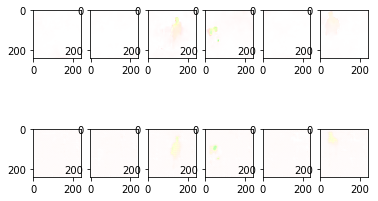

In [15]:
# Plotting the results
%matplotlib inline
index = 0

index += 11
# Testing
data = next(iter(dataloader))
    
temp_batch_size = data.shape[0]

# Previous 9 frames
input_ = data[:,0:18,:,:].cuda()
assert(input_.shape == torch.Size([temp_batch_size,18,240,240]))

# Ground truth of 10th frame for batch_size sets
ground_ = data[:,18:,:,:].cuda()
assert(ground_.shape == torch.Size([temp_batch_size,2,240,240]))

# Prediction for 10th frame for batch_size sets 
pred_ = gen.forward(input_).cuda()

print( torch.max(pred_) )
print( torch.min(pred_) )

print( torch.max(ground_) )
print( torch.min(ground_) )

ground_ = ground_.cpu().detach().numpy()
pred_ = pred_.cpu().detach().numpy()

img_1 = np.transpose(ground_,[0,2,3,1])
img_2 = np.transpose(pred_,[0,2,3,1])

print(img_1.shape)
print(img_2.shape)

fig = plt.figure()

ax1 = fig.add_subplot(2,6,1)
ax2 = fig.add_subplot(2,6,7)

ax3 = fig.add_subplot(2,6,2)
ax4 = fig.add_subplot(2,6,8)

ax5 = fig.add_subplot(2,6,3)
ax6 = fig.add_subplot(2,6,9)

ax7 = fig.add_subplot(2,6,4)
ax8 = fig.add_subplot(2,6,10)

ax9 = fig.add_subplot(2,6,5)
ax10 = fig.add_subplot(2,6,11)

ax11 = fig.add_subplot(2,6,6)
ax12 = fig.add_subplot(2,6,12)

t1 = save_flow(img_1[0])
t2 = save_flow(img_2[0])
ax1.imshow(t1)
ax2.imshow(t2)
imsave("./image_" + str(index) + "_1.png",t1)
imsave("./image_" + str(index) + "_7.png",t2)

t3 = save_flow(img_1[1])
t4 = save_flow(img_2[1])
ax3.imshow(t3)
ax4.imshow(t4)
imsave("./image_" + str(index) + "_2.png",t3)
imsave("./image_" + str(index) + "_8.png",t4)

t5 = save_flow(img_1[2])
t6 = save_flow(img_2[2])
ax5.imshow(t5)
ax6.imshow(t6)
imsave("./image_" + str(index) + "_3.png",t5)
imsave("./image_" + str(index) + "_9.png",t6)

t7 = save_flow(img_1[3])
t8 = save_flow(img_2[3])
ax7.imshow(t7)
ax8.imshow(t8)
imsave("./image_" + str(index) + "_4.png",t7)
imsave("./image_" + str(index) + "_10.png",t8)


t9 = save_flow(img_1[4])
t10 = save_flow(img_2[4])
ax9.imshow(t9)
ax10.imshow(t10)
imsave("./image_" + str(index) + "_5.png",t9)
imsave("./image_" + str(index) + "_11.png",t10)

t11 = save_flow(img_1[5])
t12 = save_flow(img_2[5])
ax11.imshow(t11)
ax12.imshow(t12)
imsave("./image_" + str(index) + "_6.png",t11)
imsave("./image_" + str(index) + "_12.png",t12)

plt.show()

In [ ]:
# class AdlDatasetTest(Dataset):
#     """Face Landmarks dataset."""

#     def __init__(self, hdf5_file, transform=None):
#         """
#         Args:
#             csv_file (string): Path to the csv file with annotations.
#             root_dir (string): Directory with all the images.
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
#         f = h5py.File(hdf5_file, 'r')

#         self.dset = f['default']
#         self.transform = transform
        
#         with open("adl_indices_test.pkl","rb") as f:
#             self.indices = pickle.load(f)

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         idx2 = self.indices[idx]
#         sample = self.dset[idx2:idx2+10]
#         sample = sample.transpose([1,2,3,0])
#         sample = sample.reshape([240,320,-1])
#         sample = sample[:,40:280,:]
#         if self.transform:
#             sample = self.transform(sample)

#         return sample